In [4]:
memory_order = ["episodic", "semantic", "both", "both-presem"]

max_history = 1024

legend_order = [
    "Hand-crafted 1: Only episodic",
    "Hand-crafted 2: Only semantic",
    "Hand-crafted 3: Both epi and sem",
    "Hand-crafted 4: Both epi and pre-sem",
]

color_order = ["orange", "dodgerblue", "yellowgreen", "deeppink"]

# should be "no_random", "only_random", "episodic_forget_random" , "semantic_forget_random",
# "episodic_answer_random", or "semantic_answer_random"
policy = "no_random"

paths = "./training-results/*/*/train.yaml"

In [5]:
from memory.utils import read_json, read_yaml
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np

In [6]:
def what_policy(config):
    policies = list(
        set(
            [
                str(val)
                for key, val in config["strategies"].items()
            ]
        )
    )
    if config["strategies"]["capacity"]["episodic"] == 0 and config["strategies"]["pretrain_semantic"]:
        return "something else"

    if "random" not in policies and "noop" not in policies:
        return "no_random"

    if (
        config["strategies"]["capacity"]["episodic"] > 0
        and config["strategies"]["capacity"]["semantic"] == 0
        and config["strategies"]["episodic_memory_manage"] == "random"
        and config["strategies"]["episodic_question_answer"] == "random"
    ):
        return "only_random"

    if (
        config["strategies"]["capacity"]["episodic"] == 0
        and config["strategies"]["capacity"]["semantic"] >= 0
        and config["strategies"]["semantic_memory_manage"] == "random"
        and config["strategies"]["semantic_question_answer"] == "random"
    ):
        return "only_random"

    if (
        config["strategies"]["capacity"]["episodic"] > 0
        and config["strategies"]["capacity"]["semantic"] > 0
        and config["strategies"]["episodic_to_semantic"] == "noop"
        and config["strategies"]["episodic_semantic_question_answer"] == "random"
    ):
        return "only_random"

    else:
        return "something else"


configs = {path: read_yaml(path) for path in tqdm(glob(paths))}
print(f"number of configs before parsing: {len(configs)}")

configs = {
    path: config
    for path, config in configs.items()
    if what_policy(config) == policy
}
print(f"number of matching ({policy}) configs: {len(configs)}")

results_raw = {
    path: read_json(path.replace("train.yaml", "results.json"))
    for path, config in tqdm(configs.items())
}

print(f"number of loaded results {policy}: {len(results_raw)}")

0it [00:00, ?it/s]

number of configs before parsing: 0
number of matching (no_random) configs: 0


0it [00:00, ?it/s]

number of loaded results no_random: 0


In [74]:
results = {key: [] for key in memory_order}
seeds = []
capacities = []
for key, result in results_raw.items():
    config = read_yaml(key)
    
    if config["strategies"]["capacity"]["episodic"] == 0 and config["strategies"]["capacity"]["semantic"] > 0:
        memory_type = "semantic"
    elif config["strategies"]["capacity"]["episodic"] > 0 and config["strategies"]["capacity"]["semantic"] == 0:
        memory_type = "episodic"
    elif config["strategies"]["capacity"]["episodic"] > 0 and config["strategies"]["capacity"]["semantic"] >= 0:
        if config["strategies"]["pretrain_semantic"]:
            memory_type = "both-presem"
        else:
            memory_type = "both"
    else:
        raise ValueError

    capacity = config["strategies"]["capacity"]["episodic"] + config["strategies"]["capacity"]["semantic"]
    accs = {split: result[-1][f"{split}_accuracy"] for split in ["train", "val", "test"]}

    seed = config["seed"]
    seeds.append(seed)
    capacities.append(capacity)

    to_append = {"capacity": capacity, "accuracy": accs, "seed": seed}

    results[memory_type].append(to_append)

assert len(set(list((dict(Counter(seeds)).values())))) == 1
seeds = set(seeds)

print("before averaging seeds:")
for key, val in results.items():
    print(key, len(val))

capacities = sorted(list(set(capacities)))


def get_mean_std(list_of_accs):
    nums = {
        split: [acc[split] for acc in list_of_accs]
        for split in ["train", "val", "test"]
    }
    means = {split: np.mean(nums[split]) for split in ["train", "val", "test"]}
    stds = {split: np.std(nums[split]) for split in ["train", "val", "test"]}
    num_samples = {split: len(nums[split]) for split in ["train", "val", "test"]}

    return {"means": means, "stds": stds, "num_samples": nums}


results = {
    key: {
        capacity: get_mean_std(
            [
                val_["accuracy"]
                for val_ in val
                if val_["capacity"] == capacity
            ]
        )
        for capacity in capacities
    }
    for key, val in results.items()
}

before averaging seeds:
episodic 50
semantic 50
both 50
both-presem 50


episodic [0.02692, 0.04824, 0.08732, 0.14472000000000002, 0.25389999999999996, 0.40432000000000007, 0.6045, 0.8222799999999999, 0.9681599999999999, 1.0]
semantic [0.023060000000000004, 0.06483999999999998, 0.12536, 0.16582000000000002, 0.27774, 0.40800000000000003, 0.5394599999999999, 0.55684, 0.5648199999999999, 0.56268]
both [0.03086, 0.05392, 0.11388000000000001, 0.20936, 0.3488, 0.59494, 0.77186, 0.8685600000000001, 0.8918200000000001, 0.96212]
both-presem [0.027340000000000003, 0.04688, 0.10837999999999999, 0.18046, 0.31989999999999996, 0.5750200000000001, 0.77598, 0.89688, 0.9803000000000001, 1.0]


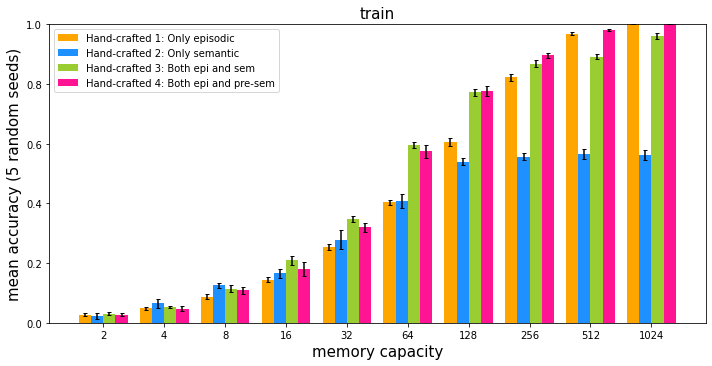

episodic [0.03166, 0.055279999999999996, 0.0971, 0.16308, 0.27030000000000004, 0.42208000000000007, 0.62636, 0.84572, 0.98106, 1.0]
semantic [0.03456, 0.07108, 0.1336, 0.19727999999999998, 0.30313999999999997, 0.45314, 0.57968, 0.5806600000000001, 0.58438, 0.5838000000000001]
both [0.037320000000000006, 0.06524, 0.1301, 0.2258, 0.38611999999999996, 0.6123000000000001, 0.78888, 0.88616, 0.9168, 0.9748199999999999]
both-presem [0.03556, 0.061119999999999994, 0.11368, 0.19766, 0.34746, 0.5904200000000001, 0.7769600000000001, 0.9105399999999999, 0.9902599999999999, 1.0]


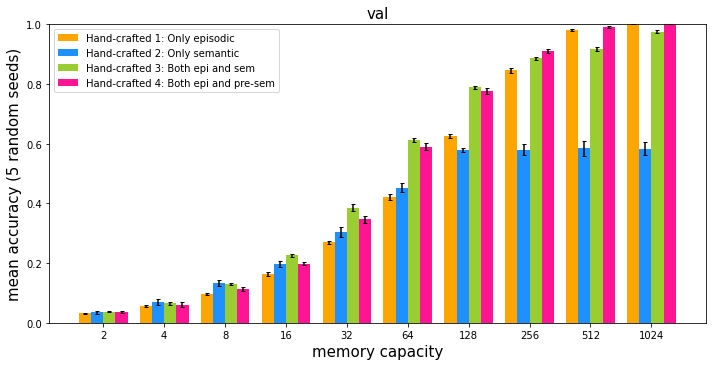

episodic [0.02286, 0.04628, 0.08848, 0.15038, 0.25276, 0.41248000000000007, 0.60782, 0.8185399999999999, 0.97346, 1.0]
semantic [0.0207, 0.0496, 0.11506000000000001, 0.15626, 0.29472, 0.44396, 0.54572, 0.5696999999999999, 0.5705, 0.57048]
both [0.03342, 0.05666, 0.10802, 0.19666, 0.35818, 0.6033000000000001, 0.77264, 0.86798, 0.8910199999999999, 0.9703199999999998]
both-presem [0.029699999999999997, 0.05272, 0.092, 0.17832, 0.33146, 0.5748, 0.7603599999999999, 0.89452, 0.98438, 1.0]


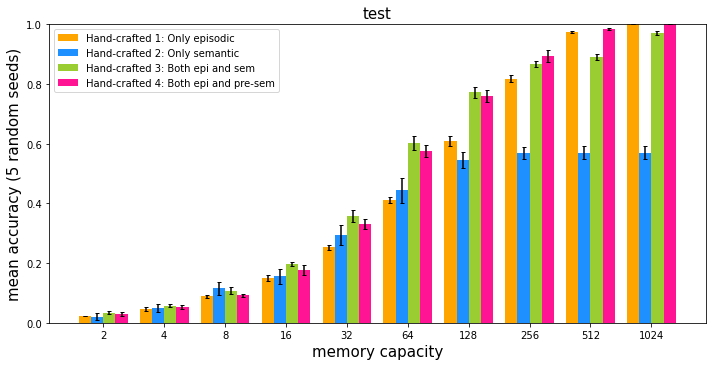

In [75]:
for split in ["train", "val", "test"]:
    capacities = list(results["episodic"])

    fig, ax = plt.subplots(figsize=(10, 5))

    idx = np.asanyarray([i for i in range(len(capacities))])

    width = 0.2

    for memory_type, w, color in zip(memory_order, [-1.5, -0.5, 0.5, 1.5], color_order):
        means = [
            val["means"][split] for key, val in sorted(results[memory_type].items())
        ]
        stds = [val["stds"][split] for key, val in sorted(results[memory_type].items())]

        print(memory_type, means)
        ax.bar(
            x=idx + w * width,
            height=means,
            yerr=stds,
            width=width,
            color=color,
            capsize=2,
        )
    ax.set_xticks(idx)
    ax.set_xticklabels(capacities)
    ax.legend(legend_order, fontsize=10, loc="upper left")
    ax.set_xlabel("memory capacity", fontsize=15)
    ax.set_ylabel(f"mean accuracy ({len(seeds)} random seeds)", fontsize=15)

    ax.set_ylim([0, 1])

    fig.tight_layout()
    plt.title(split, fontsize=15)
    plt.savefig("./figures/" + split + "-bar.pdf", bbox_inches="tight")
    plt.show()